# General relativistic precession and the long-term stability of the solar system
 *Garett Brown & Hanno Rein (2023)*
 
This notebook produces the figures found in Brown & Rein (2023).

It was made using scipy==1.10.0, matplotlib==3.6.3, and numpy==1.24.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import matplotlib.ticker as ticker
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format='retina'

# Load the advection-diffusion model
from model import model, run_model

In [2]:
# Load the N-body results
taus = np.load('nbody-data/taus.npy')
endtimes = np.load('nbody-data/endtimes.npy')
unstable = np.load('nbody-data/unstable.npy')
nsims = len(endtimes)

In [3]:
print(f' Number of unstable simulations: {len(endtimes[endtimes < 12.5e9])} / {nsims}.\n Number of unstable simulations before τ: {len([i for i in range(nsims) if endtimes[i] < taus[i]])}.')

 Number of unstable simulations: 1072 / 1280.
 Number of unstable simulations before τ: 175.


## Compare the Model to the entire ensemble of $N$-body data.

In [4]:
nruns = 100
nbins = 1001
tmax = 12.5

In [5]:
# Try to load the model data used in the paper, or generate new data from the model.
try: model_data = np.load('model-data/model_data.npy')
except:
    model_data = np.zeros((nruns, nsims))
    for i in range(nruns):
        model_data[i] = run_model(taus/1e9, tmax=tmax)

In [6]:
# Bin the different runs of the model data together to compute the mean and confidence.
xbins = np.linspace(0, tmax+0.01, nbins)
ss = np.zeros((nruns, nbins))
for i in range(nruns):
    a,b = np.histogram(model_data[i], bins=xbins)
    ss[i] = 1-np.cumsum(np.insert(a,0,0))/nsims
ms = np.mean(ss, axis=0)
md = np.std(ss, axis=0)

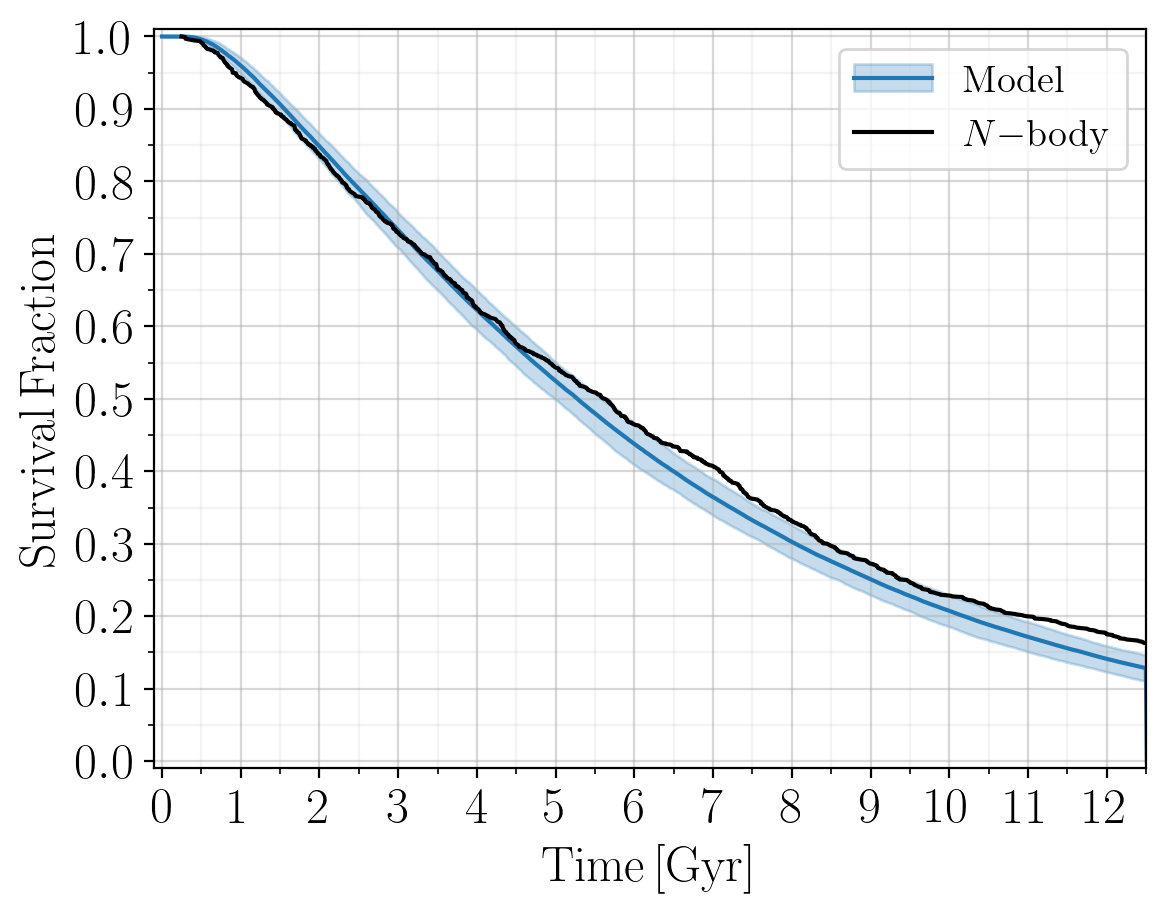

In [7]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1)

p0, = ax.plot(xbins, ms, 'C0')
p1 = ax.fill_between(xbins, ms-2*md, ms+2*md, color='C0', alpha=0.25)
    
p2, = ax.plot(np.sort(endtimes)/1e9, 1-np.arange(nsims)/nsims, 'k')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.15)

ax.legend([(p0, p1), p2], [r'$\mathrm{Model}$', r'$N\mathrm{-body}$'], scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=1)}, prop={'size': 14})
ax.set_xlim(-0.1,12.5)
ax.set_ylim(-0.01,1.01)
ax.set_ylabel(r'$\mathrm{Survival\,Fraction}$')
ax.set_xlabel(r'$\mathrm{Time \,[Gyr]}$')
plt.savefig('figures/figure3_survival_all.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compare to TAU Regimes

In [8]:
# Bin the N-body data into 4 different regimes of τ.
splits = 4
split_taus = np.array(np.array_split(taus,splits))
split_endtimes = np.array(np.array_split(endtimes,splits))
split_unstable = np.array(np.array_split(unstable, splits))

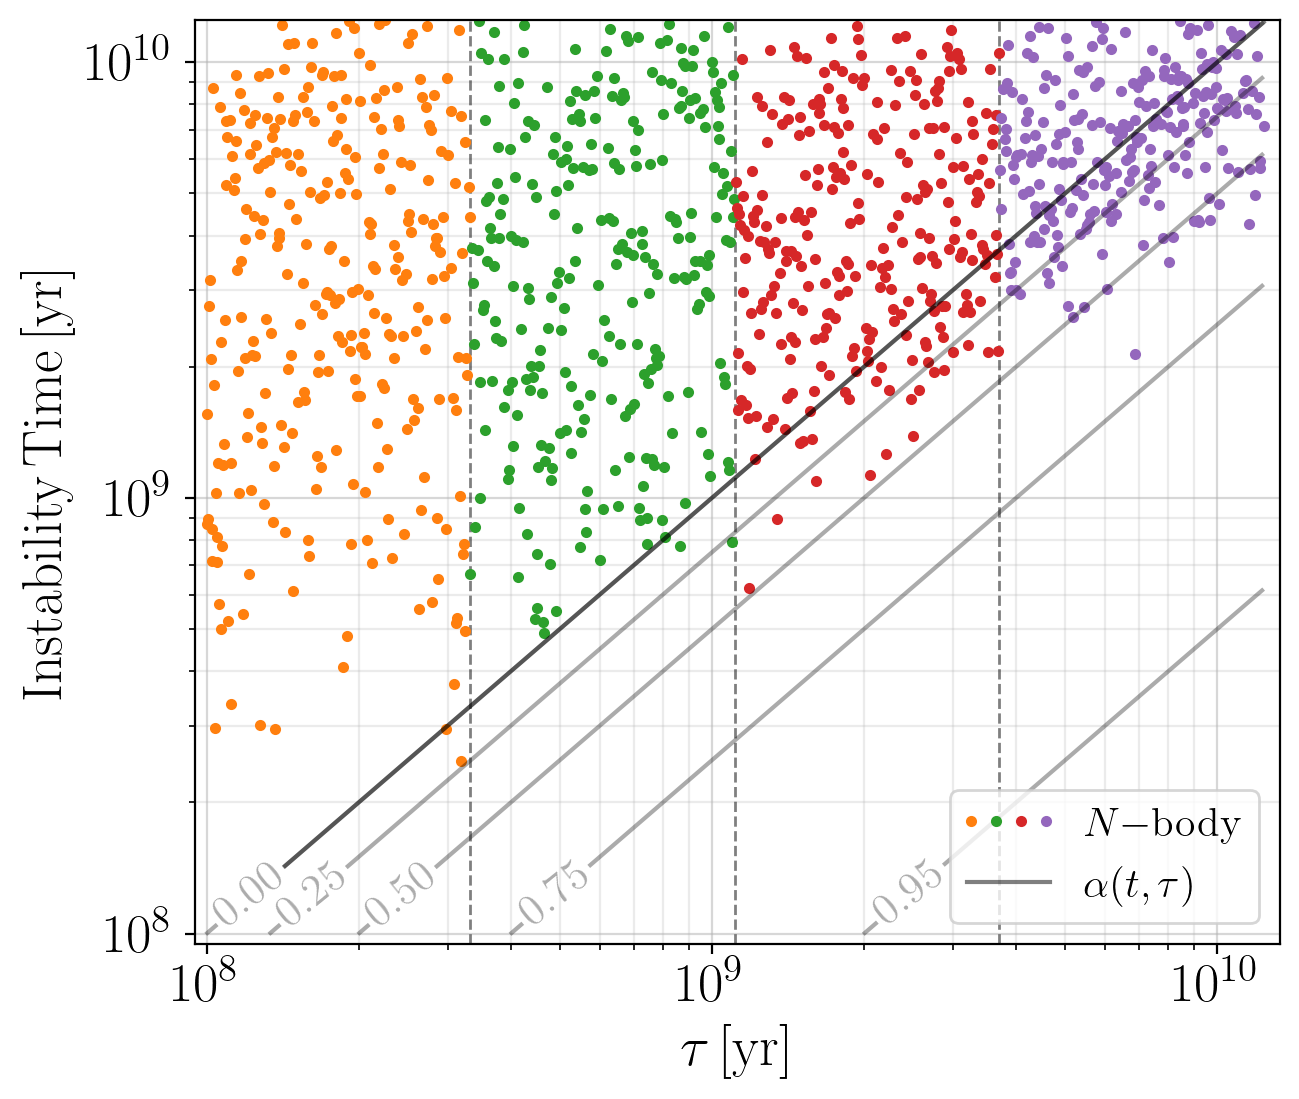

In [9]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.set_xscale('log')
ax.set_yscale('log')

inds = np.bool_(unstable)
for i in range(splits-1): ax.axvline(10**np.mean(np.log10([split_taus[i,-1],split_taus[i+1,0]])), c='k', ls='--', lw=1, alpha=0.5)
ps = []
for i in range(splits):
    inds = np.bool_(split_unstable[i])
    ps0, = ax.plot(split_taus[i,inds], split_endtimes[i,inds], f'C{(i+1)%10}.')
    ps.append(ps0)

ps1, = ax.plot(taus[96:], taus[96:], 'k', alpha=0.5)

X, Y = np.meshgrid(taus, taus)
contour_levels = [0, 0.25, 0.5, 0.75, 0.95]
manual_locations = [(1.2e8, 1.25e8), (1.6e8, 1.25e8), (2.4e8, 1.25e8), (4.85e8, 1.25e8), (2.45e9, 1.25e8)]
cs = ax.contour(X, Y, 1-Y/taus, levels=contour_levels, colors='k', alpha=0.33)
ax.clabel(cs, inline=True, fontsize=16, colors='k', inline_spacing=2.5, manual=manual_locations)

ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.25)

ax.legend([tuple(ps), ps1], [r'$N\mathrm{-body}$', r'$\alpha(t,\tau)$'], scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': 15})
ax.set_xlim([0.95*taus[0], 1.075*taus[-1]])
ax.set_ylim([0.95*taus[0], 12.5e9])
ax.set_xlabel(r'$\tau\, \mathrm{[yr]}$')
ax.set_ylabel(r'$\mathrm{Instability\, Time\, [yr]}$')
plt.savefig('figures/figure1_splits_triangle.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [10]:
# Try to load the model data used in the paper, or generate new data from the model.
try: split_model_data_set = np.load('model-data/split_model_data_set.npy')
except:
    split_model_data_set = np.zeros((splits, nruns, nsims//splits))
    for i in range(splits):
        for j in range(nruns):
            split_model_data_set[i,j] = run_model(split_taus[i]/1e9, tmax=tmax)

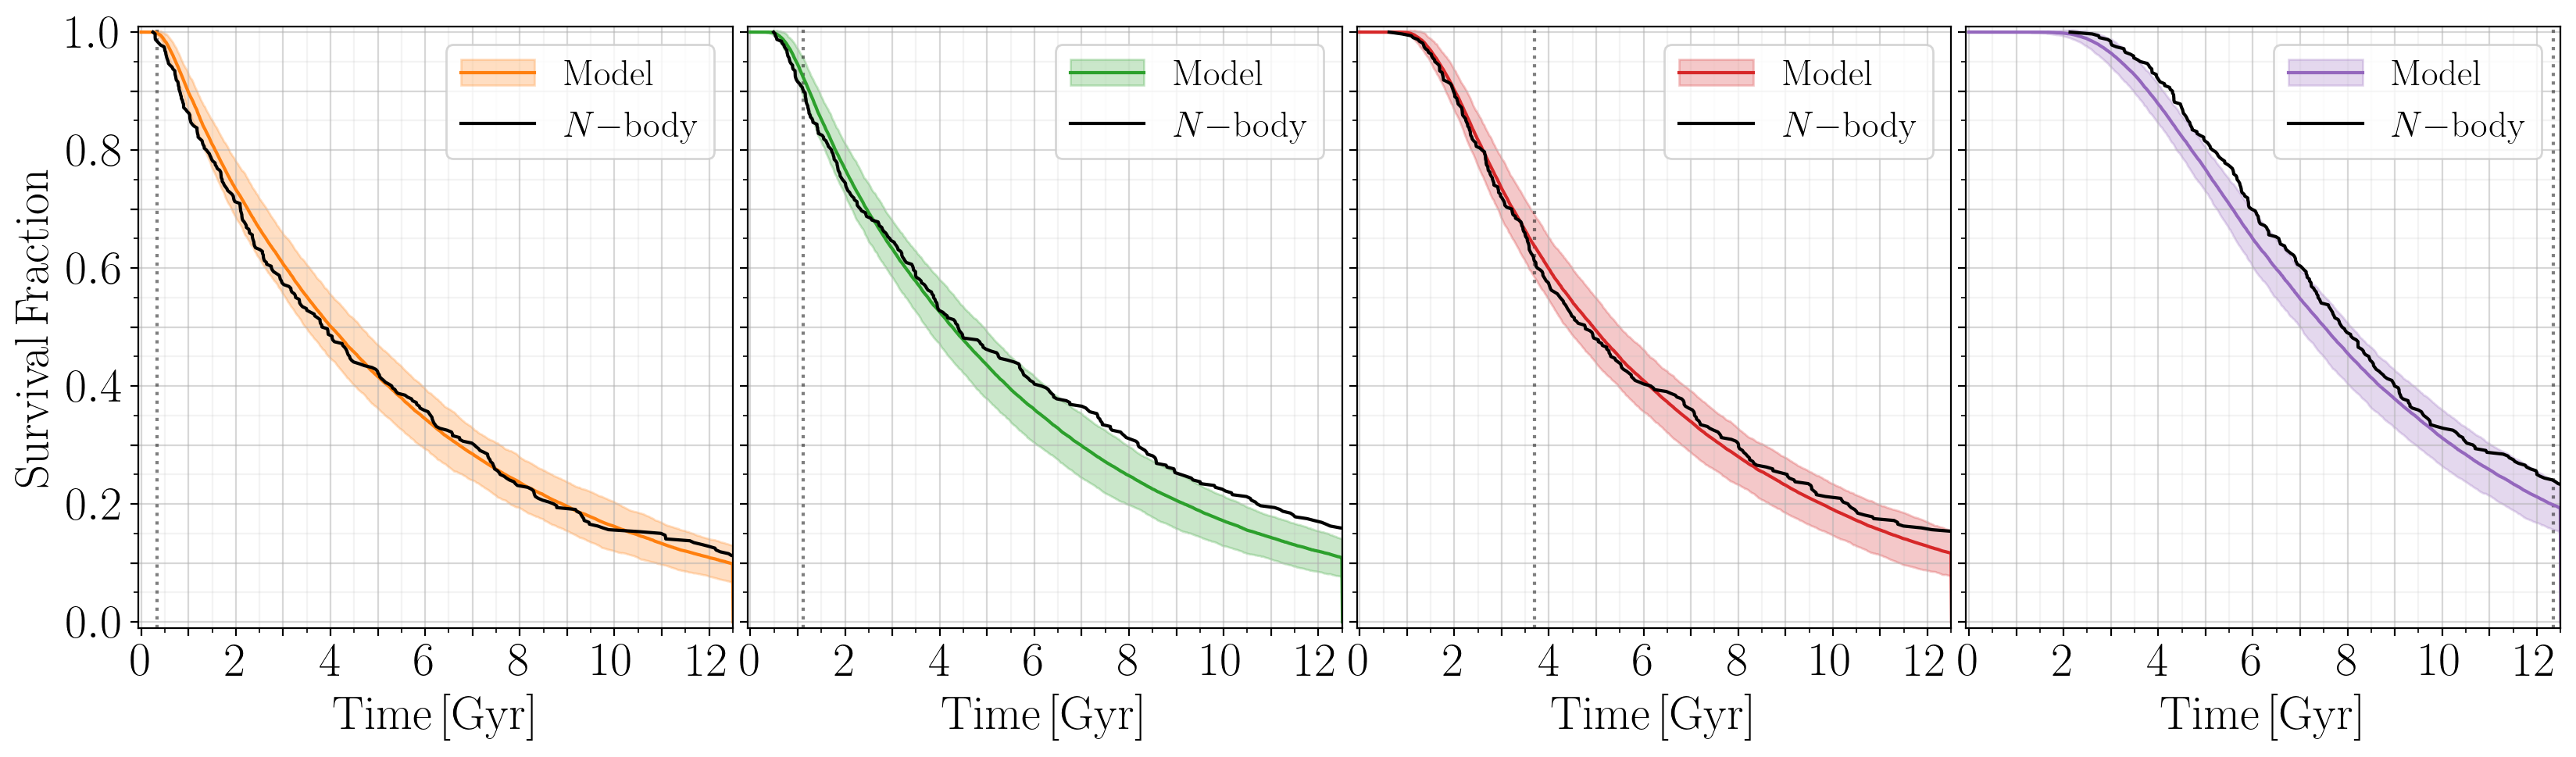

In [11]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1,splits, figsize=(5*splits,5), sharey=True, sharex=True)

ax[0].set_ylim([-0.01, 1.01])
ax[0].set_xlim([-0.06,12.5])
ax[0].set_ylabel(r'$\mathrm{Survival\,Fraction}$')
ax[0].set_xlabel(r'$\mathrm{Time \,[Gyr]}$')

for i in range(splits):
    ax[i].set_xlabel(r'$\mathrm{Time \,[Gyr]}$')
    ax[i].axvline(x=np.max(split_taus[i]/1e9), ls=':', c='k', alpha=0.5)

    # Bin the different runs of the model data together to compute the mean and confidence.
    xbins = np.linspace(0, tmax+0.01, nbins)
    ss = np.zeros((nruns, nbins))
    for j in range(nruns):
        a,b = np.histogram(split_model_data_set[i,j], bins=xbins)
        ss[j] = 1-np.cumsum(np.insert(a,0,0))/(nsims//splits)
    ms = np.mean(ss, axis=0)
    md = np.std(ss, axis=0)
    
    
    p0, = ax[i].plot(xbins, ms, f'C{i+1}')
    p1 = ax[i].fill_between(xbins, ms-2*md, ms+2*md, color=f'C{i+1}', alpha=0.25)
    
    p2, = ax[i].plot(np.sort(split_endtimes[i])/1e9, 1-np.arange(nsims//splits)/(nsims//splits), 'k')

    ax[i].legend([(p0, p1), p2], [r'$\mathrm{Model}$', r'$N\mathrm{-body}$'], scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=1)}, prop={'size': 17})
    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].grid(which='major', alpha=0.5)
    ax[i].grid(which='minor', alpha=0.15)
    for label in ax[i].xaxis.get_ticklabels()[::2]: label.set_visible(False)
    for label in ax[i].yaxis.get_ticklabels()[::2]: label.set_visible(False)

plt.subplots_adjust(wspace=0.025, hspace=0.)
plt.savefig('figures/figure4_splits_compare.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compare to Mogavero & Laskar (2021)
Compare our algorithmic implementation of a stochastic Wiener process with an upper reflecting barrier to Eq57 and Eq58 from Mogavero & Laskar (2021) (ML21).

In [12]:
from scipy.integrate import quad

In [13]:
def rho(time, T1=27.6, alpha=0.9, nsamples=1000):
    ''' Eq.57 and Eq.58 '''
    α = alpha #0.9 with GR, 0.607 without GR
    n = np.arange(nsamples) + (1.0/2.0)
    if time < 0.01*T1: return np.sqrt((α*α*T1)/(np.pi * time*time*time)) * np.exp(-(α*α*T1)/time)
    else: return (0.5*np.pi/T1) * np.sum( n * np.sin(np.pi*n*α) * np.exp(-0.25*np.pi*np.pi*n*n*time/T1))

ML_Surv = lambda t,T1,alpha: 1 - quad(rho, 0, t, args=(T1,alpha))[0]

### The case without General Relativity
Adapt the model of ML21 to the case without GR by solving for the diffusion timescale without GR. We do this by fitting the model to the results of Laskar & Gastineau (2009). We then compare it to our algorithmic implementation.

In [14]:
from scipy.optimize import root_scalar

In [15]:
def smin(tscale):
    # Compute the CDF of rho and compare it to when 60.2% of simulations go unstable.
    fnogr = lambda x: quad(rho, 0, x, args=(tscale, 0.607))[0] - 0.602
    
    # Optimize for when 60.2% of simulations go unstable at 5.0 Gyr.
    return root_scalar(fnogr, bracket=[4,6]).root - 5.0

In [16]:
print(f'The timescale of the diffusivity without GR is {root_scalar(smin, bracket=[3,3.5]).root} Gyr')

The timescale of the diffusivity without GR is 3.216507262547807 Gyr


#### Data from the appendix of Laskar & Gastineau (2009).

In [17]:
dtimes = [0.5, 1, 1.5, 2, 3, 4, 5] # Gyr
nogrdat = np.array([10, 85, 149, 259, 423, 527, 602])/1000 # Instability fraction
grdat = np.array([0, 0, 1, 2, 2, 8, 21])/2501 # Instability fraction

In [18]:
# Try to load the model data used in the paper, or generate new data from the model.

try: compare_data_GR = np.load('model-data/compare_data_GR.npy')
except:
    compare_data_GR = np.zeros((nruns, nsims))
    for i in range(nruns):
        compare_data_GR[i] = run_model([1e1000]*nsims, tmax=tmax)

try: compare_data_noGR = np.load('model-data/compare_data_noGR.npy')
except:
    compare_data_noGR = np.zeros((nruns, nsims))
    for i in range(nruns):
        compare_data_noGR[i] = run_model([1e-9]*nsims, tmax=tmax)
        
try: compare_data_nog1GR = np.load('model-data/compare_data_nog1GR.npy')
except:
    compare_data_nog1GR = np.zeros((nruns, nsims))
    for i in range(nruns):
        compare_data_nog1GR[i] = run_model([1e1000]*nsims, tmax=tmax, withoutg1GR=True)

In [19]:
# Bin the different runs of the model data together to compute the mean and confidence.

xbins = np.linspace(0, tmax+0.01, nbins)
ss_GR = np.zeros((nruns, nbins))
ss_noGR = np.zeros((nruns, nbins))
ss_nog1GR = np.zeros((nruns, nbins))
for i in range(nruns):
    a,b = np.histogram(compare_data_GR[i], bins=xbins)
    ss_GR[i] = 1-np.cumsum(np.insert(a,0,0))/nsims
    
    a,b = np.histogram(compare_data_noGR[i], bins=xbins)
    ss_noGR[i] = 1-np.cumsum(np.insert(a,0,0))/nsims

    a,b = np.histogram(compare_data_nog1GR[i], bins=xbins)
    ss_nog1GR[i] = 1-np.cumsum(np.insert(a,0,0))/nsims
    
ms_GR = np.mean(ss_GR, axis=0)
md_GR = np.std(ss_GR, axis=0)
ms_noGR = np.mean(ss_noGR, axis=0)
md_noGR = np.std(ss_noGR, axis=0)
ms_nog1GR = np.mean(ss_nog1GR, axis=0)
md_nog1GR = np.std(ss_nog1GR, axis=0)

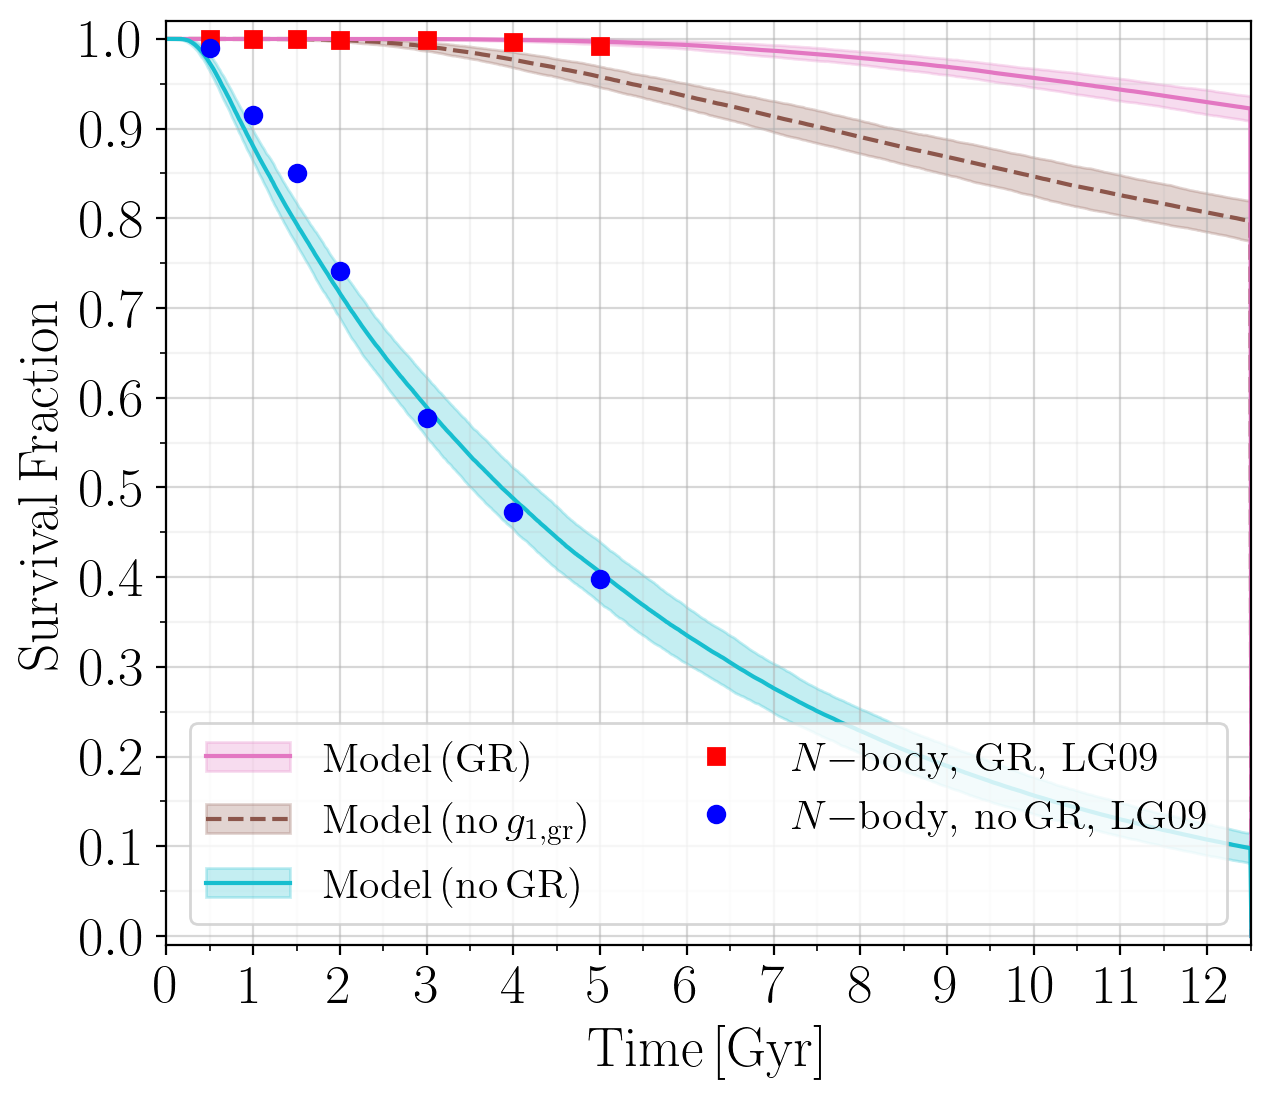

In [20]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(7,6))

pnog1GR0, = ax.plot(xbins, ms_nog1GR, 'C5--')
pnog1GR1 = ax.fill_between(xbins, ms_nog1GR-2*md_nog1GR, ms_nog1GR+2*md_nog1GR, color='C5', alpha=0.25)

pGR0, = ax.plot(xbins, ms_GR, 'C6')
pGR1 = ax.fill_between(xbins, ms_GR-2*md_GR, ms_GR+2*md_GR, color='C6', alpha=0.25)

pnoGR0, = ax.plot(xbins, ms_noGR, 'C9')
pnoGR1 = ax.fill_between(xbins, ms_noGR-2*md_noGR, ms_noGR+2*md_noGR, color='C9', alpha=0.25)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.15)

ax.set_ylabel(r'$\mathrm{Survival}$')
ax.set_xlabel(r'$\mathrm{Time \,[Gyr]}$')
pLG09, = ax.plot(dtimes, 1-grdat, 'rs')
pLG09noGR, = ax.plot(dtimes, 1-nogrdat, 'bo')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.15)

ax.legend([(pGR0, pGR1), (pnog1GR0,pnog1GR1), (pnoGR0, pnoGR1), pLG09, pLG09noGR], 
          [r'$\mathrm{Model\,(GR)}$', r'$\mathrm{Model\,(no\,}g_{1,\mathrm{gr}})$', r'$\mathrm{Model\,(no\,GR)}$', r'$N\mathrm{-body,\,GR,\,LG09}$', r'$N\mathrm{-body,\,no\,GR,\,LG09}$'],
          scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=1)}, loc=8, ncol=2,  prop={'size': 15})
ax.set_xlim(-0.01,12.5)
ax.set_ylim(-0.01,1.02)
ax.set_ylabel(r'$\mathrm{Survival\,Fraction}$')
ax.set_xlabel(r'$\mathrm{Time \,[Gyr]}$')

plt.savefig('figures/figure2_survival_comparison_ML21.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()